In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import wrds
import os
from statsmodels.sandbox.regression import gmm
from statsmodels.api import OLS

In [2]:
# Import data

def request_wrds(path: str,
                 start_date: pd.Timestamp,
                 end_date: pd.Timestamp) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    with wrds.Connection() as db:
        df_s12 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s12
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s12.to_csv(f'{path}s12.csv')

        df_s34 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s34
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s34.to_csv(f'{path}s34.csv')

        df_security = db.raw_sql(f'''
            SELECT *
            FROM ff.factors_monthly
            WHERE date >= '{start_date}' AND date <= '{end_date}'
        ''', date_cols=['date'])
        df_security.to_csv(f'{path}security.csv')

        return df_s12, df_s34, df_security


def load_wrds(path: str,
              start_date: pd.Timestamp,
              end_date: pd.Timestamp
              ) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    try:
        df_s12 = pd.read_csv(f'{path}s12.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12(df_s12)

        df_s12type5 = pd.read_csv(f'{path}s12type5.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12type5(df_s12type5)

        df_s34 = pd.read_csv(f'{path}s34.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s34(df_s34)

        df_beta = pd.read_csv(f'{path}beta.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_beta(df_beta)

        df_security = pd.read_csv(f'{path}security.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_security(df_security)

        return df_s12, df_s12type5, df_s34, df_beta, df_security
    except FileNotFoundError:
        return request_wrds(path, start_date, end_date)


def clean_imports(df_s12,
                  df_s12type5,
                  df_s34,
                  df_beta,
                  df_security,
                  start_date,
                  end_date
                  ) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):

    df_s12_clean = clean_s12(df_s12, start_date, end_date)
    log_clean_s12(df_s12_clean)

    df_s12type5_clean = clean_s12type5(df_s12type5, start_date, end_date)
    log_clean_s12type5(df_s12type5_clean)

    df_s34_clean = clean_s34(df_s34, start_date, end_date)
    log_clean_s34(df_s34_clean)

    df_beta_clean = clean_beta(df_beta, start_date, end_date)
    log_clean_beta(df_beta_clean)

    df_security_clean = clean_security(df_security, start_date, end_date)
    log_clean_security(df_security_clean)

    return df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean


def clean_s12(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'fundno',
        'rdate',
        'cusip',
        'shares'
    ]
    return (df[columns]
            .dropna(how='any', subset=['fundno', 'shares', 'cusip'])
            .rename(columns={
                'rdate': 'date',
                'fundno': 'inv_id',
                'cusip': 'asset_id'})
            .assign(date=lambda x: x['date'].apply(fix_date, args=(start_date, end_date)))
            .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last')
            .set_index(['inv_id', 'date', 'asset_id']))


def clean_s12type5(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    return (df
            .rename(columns={'fdate': 'date', 'fundno': 'inv_id'})
            .assign(
                date=lambda x: x['date'].apply(fix_date, args=(start_date, end_date)))
            .dropna(how='any', subset=['inv_id', 'date'])
            .set_index(['inv_id', 'date']))


def clean_s34(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'mgrno',
        'rdate',
        'typecode',
        'cusip',
        'prc',
        'shrout2',
        'shares'
    ]
    return (df[columns]
            .dropna(how='any', subset=['cusip', 'shares'])
            .rename(columns={
                'rdate': 'date',
                'mgrno': 'inv_id',
                'cusip': 'asset_id'})
            .assign(
                date=lambda x: x['date'].apply(fix_date, args=(start_date, end_date)),
                backup_holding=lambda x: x['shares'] * x['prc'],
                backup_me=lambda x: x['shrout2'] * x['prc'] * 1000,
                typecode=lambda x: x['typecode'].fillna(0).astype(int))
            .astype({'inv_id': 'str'})
            .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last')
            .drop(columns=['prc', 'shrout2'])
            .set_index(['inv_id', 'date', 'asset_id']))


def clean_beta(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns=[
        'PERMNO',
        'DATE',
        'b_mkt',
        'b_smb',
        'b_hml'
    ]
    offset = pd.DateOffset(months=6)
    return (df[columns]
            .dropna()
            .rename(columns={
                'DATE': 'date',
                'PERMNO':'permno'})
            .assign(
                date=lambda x: x['date'].apply(fix_date, args=(start_date, end_date)) + offset)
            .drop_duplicates(subset=['date', 'permno'], keep='last')
            .set_index(['date', 'permno']))


def clean_security(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'LPERMNO',
        'cusip',
        'datadate',
        'prccm',
        'cshoq'
    ]
    return (df[columns]
            .dropna(how='any', subset=['cusip', 'prccm', 'cshoq'])
            .rename(columns={
                'LPERMNO': 'permno',
                'cusip': 'asset_id',
                'prccm': 'prc',
                'cshoq': 'shrout',
                'datadate': 'date'})
            .assign(
                shrout=lambda x: x['shrout'] * 1000000,
                asset_id=lambda x: x['asset_id'].apply(lambda s: s[:-1]),
                date=lambda x: x['date'].apply(fix_date, args=(start_date, end_date)))
            .drop_duplicates(subset=['date', 'permno'], keep='last')
            .set_index(['date', 'permno']))


def fix_date(date: str, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.Timestamp:
    date_converted = pd.Timestamp(date) - pd.offsets.MonthEnd()
    date_filtered = np.NaN if (date_converted < start_date) or (date_converted > end_date) else date_converted
    return date_filtered

In [3]:
# Stocks Monthly

def merge_assets_factors(df_assets: pd.DataFrame, df_factors: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(left=df_assets,
                      right=df_factors,
                      how='inner',
                      left_index=True,
                      right_index=True)
    df_merged_indexed = (df_merged
                         .reset_index()
                         .assign(date=lambda x: x['date'] - pd.offsets.BQuarterEnd())
                         .drop_duplicates(subset=['date', 'asset_id'], keep='last')
                         .set_index(['date', 'asset_id']))
    log_asset_merge(df_merged_indexed)
    return df_merged_indexed


# Manager / Holdings

def match_fund_manager(df_fund: pd.DataFrame, df_manager: pd.DataFrame, df_key: pd.DataFrame) -> pd.DataFrame:
    # TODO
    # df_fund_wkey = df_fund.assign(mgrno=lambda x: df_key.loc[x.index.get_level_values(0), 'mgrcocd'])
    # df_merged = df_manager.merge(df_fund_wkey, how='outer', on='mgrno')
    
    df_fund_manager = (df_manager
                       .reset_index()
                       .assign(date=lambda x: x['date'] - pd.offsets.BQuarterEnd())
                       .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last')
                       .set_index(['inv_id', 'date', 'asset_id']))
    log_holding_merge(df_fund_manager)
    return df_fund_manager


def merge_holding_factor(df_holding: pd.DataFrame, df_asset: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_holding,
        right=df_asset,
        how='left',
        left_index=True,
        right_index=True,
        indicator=True
    )

    df_holding_factor = (df_merged
                         .assign(
                           shares=lambda x: np.minimum(x['shares'], x['shrout']),
                           ccm_holding=lambda x: x['prc'] * x['shares'],
                           ccm_me=lambda x: x['prc'] * x['shrout'],
                           holding=lambda x: x['ccm_holding'].fillna(x['backup_holding']) / 1000000,
                           me=lambda x: x['ccm_me'].fillna(x['backup_me']) / 1000000,
                           type_code=lambda x: x['typecode'].fillna(0))
                         .drop(columns=['ccm_holding', 'backup_holding', 'ccm_me', 'backup_me'])
                         .dropna(subset=['holding', 'me'])
                         .reorder_levels(['inv_id', 'date', 'asset_id']))
    log_holding_factor_merge(df_holding_factor)
    return df_holding_factor


def create_household_sector(df_holding_factor: pd.DataFrame) -> pd.DataFrame:
    df_household = (df_holding_factor
                      .groupby(['date', 'asset_id'])
                      .agg({
                        'shares': 'sum',
                        'prc': 'last',
                        'shrout': 'last',
                        'b_mkt': 'last',
                        'b_smb': 'last',
                        'b_hml': 'last',
                        'holding': 'sum',
                        'me': 'last',
                        '_merge': 'last'})
                      .assign(
                        shares=lambda x: np.maximum(x['shrout'] - x['shares'], 0),
                        holding=lambda x: np.maximum(x['me'] - x['holding'], 0),
                        inv_id='0',
                        typecode=0)
                    .set_index('inv_id', append=True)
                    .reorder_levels(['inv_id', 'date', 'asset_id']))
    log_household_sector(df_household)
    df_concat = pd.concat([df_holding_factor, df_household])
    return df_concat

def create_outside_asset(df_household: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    mask = df_household['_merge'] == 'both'
    df_inside = df_household[mask].drop(columns='_merge')
    df_outside = (df_household[~mask]
                  .groupby(['inv_id', 'date'])
                  .agg({
                    'typecode': 'last',
                    'holding': 'sum'})
                  .assign(asset_id='-1')
                  .set_index('asset_id', append=True))
    log_outside_asset(df_outside)
    return df_inside, df_outside

In [39]:
# Data

def calc_inv_aum(df_inside: pd.DataFrame, df_outside: pd.DataFrame) -> pd.DataFrame:
    df_in_aum = (df_inside
                 .groupby(['inv_id', 'date'])
                 .agg({
                   'holding': 'sum',
                   'shares': 'count',
                   'typecode': 'last'})
                 .rename(columns={
                   'holding': 'in_aum',
                   'shares': 'n_holding'}))

    df_out_aum = (df_outside
                  .groupby(['inv_id', 'date'])
                  .agg({
                    'holding': 'sum',
                    'typecode': 'last'})
                  .rename(columns={'holding': 'out_aum'}))

    df_merged = pd.merge(
        left=df_in_aum,
        right=df_out_aum,
        how='outer',
        left_index=True,
        right_index=True)
    
    df_inv_aum = (df_merged
                  .assign(
                    typecode=lambda x: x['typecode_x'].fillna(x['typecode_y']),
                    n_holding=lambda x: x['n_holding'].fillna(0),
                    out_aum=lambda x: x['out_aum'].fillna(0),
                    in_aum=lambda x: x['in_aum'].fillna(0),
                    aum=lambda x: x['out_aum'] + x['in_aum'])
                  .drop(columns=['typecode_x', 'typecode_y']))

    log_inv_aum(df_inv_aum)
    return df_inv_aum


def bin_concentrated_inv(df_inside: pd.DataFrame, df_inv_aum: pd.DataFrame, min_n_holding: int) -> (pd.DataFrame, pd.DataFrame):
    household_mask = (df_inv_aum['out_aum'] == 0) | (df_inv_aum['in_aum'] == 0) | (df_inv_aum['aum'] < 10)
    df_valid = (df_inv_aum
                .reset_index()
                .assign(
                    inv_id=lambda x: x['inv_id'].mask(household_mask.values, '0'),
                    typecode=lambda x: x['typecode'].mask(household_mask.values, 0))
                .set_index(['inv_id', 'date']))
    
    diversified_mask = df_valid['n_holding'] >= min_n_holding
    df_aum_diversified = df_valid[diversified_mask]
    
    def calc_bin(df_date_type: pd.DataFrame) -> pd.Series:
        typecode = df_date_type['typecode'].iloc[0]
        n_bins = np.ceil(df_date_type['n_holding'].sum() / (2 * min_n_holding)).astype(int)
        if (n_bins <= 1) or (typecode == 0):
            return pd.Series('0', index=df_date_type.index)
        else:
            return pd.qcut(x=df_date_type['aum'], q=n_bins, labels=False).apply(fix_qcut_bin, args=(str(typecode),))

    def fix_qcut_bin(bin: int, typecode: str) -> str:
        return typecode + ':' + str(bin)
    
    df_aum_concentrated = df_valid[~diversified_mask].assign(
        bin = lambda x: x.groupby(['date', 'typecode']).apply(calc_bin).reset_index(drop=True))
    df_concentrated_binned = (df_aum_concentrated
                              .groupby(['bin', 'date'])
                              .agg({
                                'in_aum': 'sum',
                                'out_aum': 'sum',
                                'aum': 'sum',
                                'typecode': 'last'})
                              .rename_axis(index={'bin': 'inv_id'}))
    df_aum_binned = (pd.concat([
                        df_aum_diversified, 
                        df_concentrated_binned])
                     .assign(
                       out_weight=lambda x: x['out_aum'] / x['aum'],
                       in_weight=lambda x: x['in_aum'] / x['aum']))
    df_inside_merged = pd.merge(
        left=df_inside,
        right=df_aum_concentrated['bin'],
        how='left',
        left_index=True,
        right_index=True)
    df_inside_binned = (df_inside_merged
                        .reset_index()
                        .assign(bin=lambda x: x['bin'].fillna(x['inv_id']))
                        .groupby(['bin', 'date', 'asset_id'])
                        .agg({
                          'holding': 'sum',
                          'prc': 'last',
                          'shrout': 'last',
                          'me': 'last',
                          'b_mkt': 'last',
                          'b_smb': 'last',
                          'b_hml': 'last'})
                        .rename_axis(index={'bin': 'inv_id'}))
    log_bins(df_inside_binned, df_aum_binned)
    return df_inside_binned, df_aum_binned


def assetid_byinv(df_holding: pd.DataFrame) -> pd.Series:
    return df_holding.reset_index('asset_id')['asset_id']


def calc_inv_universe(df_holding: pd.DataFrame, n_quarters: int) -> pd.DataFrame:
    df_assetid_byinv = assetid_byinv(df_holding).sort_index()
    idx_inv_universe = df_assetid_byinv.index.unique()
    df_inv_universe = pd.DataFrame(index=idx_inv_universe, columns=['inv_universe'])
    offset = pd.DateOffset(months=3 * n_quarters)

    def calc_past_quarters(i: int, d: pd.Timestamp) -> np.array:
        prev_date = d - offset
        asset_id_within_range = df_assetid_byinv.loc[i].loc[prev_date:d]
        inv_uni = asset_id_within_range.unique().tolist()
        return inv_uni

    for (inv_id, date) in idx_inv_universe.to_flat_index():
        inv_uni = calc_past_quarters(inv_id, date)
        df_inv_universe.loc[(inv_id, date), 'inv_universe'] = inv_uni

    df_inv_universe = df_inv_universe.assign(uni_size=lambda x: x['inv_universe'].apply(len))
    log_inv_universe(df_inv_universe)
    return df_inv_universe


def create_equal_allocation(df_inv_universe: pd.DataFrame, df_aum_binned: pd.DataFrame) -> pd.DataFrame:
    df_equal_alloc = pd.merge(
        left=df_inv_universe,
        right=df_aum_binned,
        how='inner',
        left_index=True,
        right_index=True)
    cutoff = 0.95
    return (df_equal_alloc
            .assign(
                iweight=lambda x: x['n_holding'] / x['uni_size'],
                persis=lambda x: (x['iweight'] >= cutoff) & (x.index.get_level_values('inv_id') != '0'),
                allocation=lambda x: x['persis'] * x['aum'] / (x['uni_size'] + 1))
            .explode('inv_universe')
            .rename(columns={'inv_universe':'asset_id'})
            .set_index('asset_id', append=True))


def create_total_allocation(df: pd.DataFrame) -> pd.DataFrame:
    return (df['allocation']
            .groupby('asset_id')
            .sum())


def create_instrument(df_inv_universe: pd.DataFrame, df_aum_binned: pd.DataFrame) -> pd.DataFrame:
    df_equal_allocation = create_equal_allocation(df_inv_universe, df_aum_binned)
    total_allocation = create_total_allocation(df_equal_allocation)
    df_instrument = df_equal_allocation.assign(iv_me=lambda x: total_allocation - x['allocation'])
    log_instrument(df_instrument)
    return df_instrument

In [44]:
# Estimation

def calc_holding_weights(df_instrument: pd.DataFrame, df_inside_binned: pd.DataFrame, min_holding: int) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_instrument,
        right=df_inside_binned,
        how='inner',
        left_index=True,
        right_index=True)
    
    mask = (df_merged['holding'] > 0) & (df_merged['n_holding'] >= min_holding) & (df_merged['out_weight'] > 0) & (df_merged['in_weight'] > 0) & (df_merged['me'] > 0) & (df_merged['iv_me'] > 0)

    df_weights = (df_merged.loc[mask]
                 .assign(
                   ln_me=lambda x: np.log(x['me']),
                   ln_iv_me=lambda x: np.log(x['iv_me']),
                   weight=lambda x: x['holding'] / x['aum'],
                   ln_weight=lambda x: np.log(x['weight']),
                   rweight=lambda x: x['weight'] / x['out_weight'],
                   ln_rweight=lambda x: np.log(x['rweight']),
                   mean_ln_rweight=lambda x: x['ln_rweight'].groupby(['inv_id', 'date']).transform('mean'),
                   const=1)
                .reset_index('asset_id'))
    
    log_holding_weights(df_weights)
    return df_weights


def unpack_result(result: gmm.GMMResults) -> dict:
    return result.params


def momcond_1(params, exog):
    upper_bound = 0.999
    exog = exog.T
    
    beta_ln_me = params[0]
    beta_characteristics = params[1:]
    
    ln_me = exog[0]
    mean_ln_rweight = exog[1]
    arr_characteristics = exog[2:]
    
    ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
    characteristics_term = np.dot(beta_characteristics, arr_characteristics)
    pred_weight = ln_me_term + characteristics_term + mean_ln_rweight
    
    return pred_weight


def momcond_2(params, exog):
    upper_bound = 0.9999
    exog = exog.T
    
    beta_ln_me = params[0]
    beta_characteristics = params[1:]
    
    ln_me = exog[0]
    rweight = exog[1]
    mean_ln_rweight = exog[2]
    arr_characteristics = exog[3:]
    
    ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
    characteristics_term = np.dot(beta_characteristics, arr_characteristics)
    pred_weight = np.exp(-1 * (ln_me_term + characteristics_term + mean_ln_rweight))
    
    return rweight * pred_weight
        

def estimate_model(df_weights: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    
    def fit_inv_date_1(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        exog = np.asarray(df_inv_date[['ln_me', 'mean_ln_rweight'] + characteristics])
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'mean_ln_rweight'] + characteristics])
        n = exog.shape[0]
        endog = np.asarray(df_inv_date['ln_rweight'])
        start_params = np.zeros(len(params))
        w0inv = np.dot(instrument.T, instrument) / n
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_1)
            result = model.fit(
                start_params=start_params,
                maxiter=0,
                inv_weights=w0inv)
            log_results(result, params)
            return result
        except np.linalg.LinAlgError:
            print('Linear Algebra Error')
            print(f'Investor Id:  {df_inv_date.index.get_level_values(0).unique()}')
            print(f'Date:  {df_inv_date.index.get_level_values(1).unique()}')
            return np.NaN
    
    
    def fit_inv_date_2(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        exog = np.asarray(df_inv_date[['ln_me', 'rweight', 'mean_ln_rweight'] + characteristics], dtype=np.longdouble)
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'rweight', 'mean_ln_rweight'] + characteristics], dtype=np.longdouble)
        n = exog.shape[0]
        endog = np.ones(n, dtype=np.longdouble)
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_1)
            w0inv = np.dot(instrument.T, instrument) / n
            start_params = np.zeros(len(params))
            result = model.fit(
                start_params=start_params,
                maxiter=0,
                inv_weights=w0inv)
            log_results(result, params)
            return result
        except np.linalg.LinAlgError:
            print('Singular Matrix Error')
            print(f'Investor Id:  {df_inv_date.index.get_level_values(0).unique()}')
            print(f'Date:  {df_inv_date.index.get_level_values(1).unique()}')
            return np.NaN
    
    
    df_model = df_weights.assign(
        gmm_result=lambda x: x.groupby(['inv_id', 'date']).apply(fit_inv_date_1),
        lst_params=lambda x: x['gmm_result'].apply(unpack_result))
    df_model[params] = pd.DataFrame(df_model['lst_params'].tolist(), index=df_model.index)
    df_model = df_model.drop(columns='lst_params')
    
    log_params(df_model)
    return df_model


def calc_latent_demand(df_model: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    upper_bound = 0.9999
    
    df_results = df_model.assign(
        beta_ln_me=lambda x: upper_bound - np.exp(-1 * x['beta_ln_me']),
        char_demand=lambda x: np.einsum('ij,ij->i', x[['ln_me'] + characteristics], x[params]),
        pred_rweight=lambda x: np.exp(-1 * (x['char_demand'] + x['mean_ln_rweight'])),
        latent_demand=lambda x: x['rweight'] * x['pred_rweight'])
    log_latent_demand(df_results)
    return df_results

In [6]:
# Figures

def check_moment_condition(df_results: pd.DataFrame):
    df_mom = (df_results
              .groupby(['inv_id', 'date'])
              .agg({
                'latent_demand': 'mean',
                'n_holding': 'last',
                'uni_size': 'last'})
              .assign(
                iweight=lambda x: x['n_holding'] / x['uni_size'],
                latent_demand=lambda x: x['latent_demand'] * x['iweight']))
    
    epsilon = .0001
    mask = (df_mom['latent_demand'] > 1 - epsilon) & (df_mom['latent_demand'] < 1 + epsilon)
    valid_rate = len(df_mom[mask]) / len(df_mom)
    print(f'Percentage of valid portfolios:  {100*valid_rate:.4f}')
    return df_mom


def critical_value_test(df_results: pd.DataFrame, characteristics: list, figure_path: str):
    
    def iv_reg(df_inv_date: pd.DataFrame):
        y = df_inv_date['ln_me']
        X = df_inv_date[['ln_iv_me'] + characteristics]
        model = OLS(y, X)
        result = model.fit()
        t_stat = result.tvalues.iloc[0]
        return t_stat
    
    df_iv = (df_results
             .groupby(['inv_id', 'date'])
             .apply(iv_reg)
             .to_frame('t_stat')
             .groupby('date')
             .min()
             .reset_index())
    
    g = sns.relplot(
        data=df_iv, 
        x='date', 
        y='t_stat', 
        kind='line')
    g.refline(
        y=4.05,
        linestyle='--')
    g.set_axis_labels('Date', 'First stage t-statistic')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'instrument_validity.png'))


def test_index_fund(df_results: pd.DataFrame, characteristics: list, params: list, figure_path: str):
    index_id = '90457'
    mask = df_results.index.get_level_values(0) == index_id
    df_index_fund = (df_results
                     .loc[mask]
                     .assign(
                        ln_rweight=lambda x: x['ln_me'] + x['mean_ln_rweight']))
    
    df_index_fund_model = estimate_model(df_index_fund, characteristics, params)
    df_index_fund_result = calc_latent_demand(df_index_fund_model, characteristics, params)
    
    cols = params + ['latent_demand']
    for param in cols:
        g = sns.relplot(data=df_index_fund_result, 
                        x='date',
                        y=param,
                        kind='line')
        g.set_axis_labels('Date', f'{get_readable_param(param)}')
        g.despine()
        plt.savefig(os.path.join(figure_path, f'index_fund_{param}.png'))
    

def graph_type_params(df_results: pd.DataFrame, params: list, figure_path: str):
    cols = params + ['latent_demand']

    df_types = df_results.copy()
    df_types[cols] = df_types[cols].apply(lambda x: x * df_results['aum'])
    df_types = (df_types
                .groupby(['typecode', 'date'])
                [cols]
                .sum()
                .apply(lambda x: x / df_results.groupby(['typecode', 'date'])['aum'].sum()))
    
    for param in cols:
        g = sns.relplot(data=df_types, 
                        x='date',
                        y=param,
                        hue='typecode',
                        kind='line')
        g.set_axis_labels('Date', f'mean_{get_readable_param(param)}')
        g.legend.set_title('Institution Type')
        g.despine()
        plt.savefig(os.path.join(figure_path, f'{param}.png'))


def graph_std_latent_demand(df_results: pd.DataFrame, figure_path: str):
    df_ld = (df_results
         .groupby(['inv_id', 'date'])
         .agg({
            'latent_demand': 'std',
            'aum': 'last',
            'typecode': 'last'})
         .assign(latent_demand=lambda x: x['latent_demand'] * x['aum'])
         .groupby(['typecode', 'date'])
         .agg({
            'latent_demand': 'mean',
            'aum': 'sum'})
         .assign(latent_demand=lambda x: x['latent_demand'] / x['aum']))
    
    g = sns.relplot(data=df_ld, 
                    x='date',
                    y='latent_demand',
                    hue='typecode',
                    kind='line')
    g.set_axis_labels('Date', 'Standard Deviation of Latent Demand')
    g.legend.set_title('Institution Type')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'std_latent_demand.png'))


def create_tables(df_instrument: pd.DataFrame, df_inv_uni: pd.DataFrame):
    df_pctile = df_inv_uni.assign(pctile=0)
    arr_dates = df_pctile.index.get_level_values('date').unique()
    
    for date in arr_dates:
        data = df_pctile.loc[date, 'aum']
        df_pctile.loc[date, 'pctile'] = pd.qcut(data, q=100)
        
    df_grouped_pctile = (df_pctile['uni_persistence']
                         .groupby(['pctile'])
                         .median())
    print(df_grouped_pctile.head(10))

    
def get_param_cols(cols: list) -> list:
    return ['beta_' + col for col in cols]


def get_readable_param(name: str) -> str:
    return name.replace('_', ' ').title()

In [7]:
# Log

def log_import_s12(df_s12: pd.DataFrame):
    dateindex_s12 = df_s12['rdate']
    print('Imported s12')
    print('Number of holdings:  ', len(df_s12))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_import_s12type5(df_s12type5: pd.DataFrame):
    dateindex_s12type5 = df_s12type5['fdate']
    print()
    print('Imported s12type5')
    print('Number of holdings:  ', len(df_s12type5))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_import_s34(df_s34: pd.DataFrame):
    dateindex_s34 = df_s34['rdate']
    print()
    print('Imported s34')
    print('Number of holdings:  ', len(df_s34))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_import_beta(df_beta: pd.DataFrame):
    dateindex_ffm = df_beta['DATE']
    print()
    print('Imported betas')
    print('Number of dates:  ', len(df_beta))
    print('Earliest date:  ', min(dateindex_ffm))
    print('Latest date:  ', max(dateindex_ffm))


def log_import_security(df_security: pd.DataFrame):
    dateindex_security = df_security['datadate']
    print()
    print('Imported security')
    print('Number of holdings:  ', len(df_security))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_clean_s12(df_s12_clean: pd.DataFrame):
    dateindex_s12 = df_s12_clean.index.get_level_values('date')
    print('Cleaned s12')
    print('Number of holdings:  ', len(df_s12_clean))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_clean_s12type5(df_s12type5_clean: pd.DataFrame):
    dateindex_s12type5 = df_s12type5_clean.index.get_level_values('date')
    print()
    print('Cleaned s12type5')
    print('Number of firm/dates:  ', len(df_s12type5_clean))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_clean_s34(df_s34_clean: pd.DataFrame):
    dateindex_s34 = df_s34_clean.index.get_level_values('date')
    print()
    print('Cleaned s34')
    print('Number of holdings:  ', len(df_s34_clean))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_clean_beta(df_beta_clean: pd.DataFrame):
    dateindex_beta = df_beta_clean.index.get_level_values('date')
    print()
    print('Cleaned beta')
    print('Number of dates:  ', len(df_beta_clean))
    print('Earliest date:  ', min(dateindex_beta))
    print('Latest date:  ', max(dateindex_beta))


def log_clean_security(df_security_clean: pd.DataFrame):
    dateindex_security = df_security_clean.index.get_level_values('date')
    print()
    print('Cleaned security')
    print('Number of asset/dates:  ', len(df_security_clean))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_holding_merge(df_merged: pd.DataFrame):
    print('Merged s12 and s34')
    print('Number of holdings:  ', len(df_merged))
    print()


def log_asset_merge(df_merged: pd.DataFrame):
    print('Merged assets and factors')
    print('Number of assets/dates:  ', len(df_merged))
    print()


def log_holding_factor_merge(df_merged: pd.DataFrame):
    print('Merged holdings and factors')
    print('Number of assets/dates:  ', len(df_merged))
    print()


def log_household_sector(df_household: pd.DataFrame):
    print('Created household sector')
    print('Number of holdings:  ', len(df_household))


def log_outside_asset(df_holding: pd.DataFrame):
    print('Created outside asset')
    print('Number of holdings:  ', len(df_holding))


def log_inv_aum(df_inv_aum: pd.DataFrame):
    print('Calculated investor AUM')
    print(df_inv_aum.describe())


def log_bins(df_inside_binned: pd.DataFrame, df_aum_binned: pd.DataFrame):
    print('Binned investors')
    print('Number of investors by holding:  ', len(df_inside_binned.index.unique('inv_id')))
    print('Number of investors by aum:  ', len(df_aum_binned.index.unique('inv_id')))


def log_inv_universe(df_inv_uni: pd.DataFrame):
    print('Created investment universe')
    print(df_inv_uni.describe())
    

def log_instrument(df_instrument: pd.DataFrame):
    print('Created market equity instrument')
    print(df_instrument.describe())
    print()
    

def log_holding_weights(df_model: pd.DataFrame):
    print('Calculated holding weights')
    print(df_model.describe())


def log_results(result, params):
    print(result.summary(yname='Latent demand', xname=params))
    print()
    

def log_params(df_params: pd.DataFrame):
    print('Estimated parameters')
    print()
    
    
def log_latent_demand(df_results: pd.DataFrame):
    print('Calculated latent demand')
    print()

In [8]:
# Global parameters

sns.set_theme(style='ticks', palette=None)

input_path = 'data/'
output_path = 'output/'
figure_path = 'figures/'

start_date = pd.Timestamp('2012-01')
end_date = pd.Timestamp('2017-12')

characteristics = [
    'b_mkt',
    'b_smb',
    'b_hml'
] + ['const']
params = ['beta_ln_me'] + get_param_cols(characteristics)
dict_typecode = {
     0: 'Households',
     1: 'Banks',
     2: 'Insurance companies',
     3: 'Investment advisors',
     4: 'Mutual funds',
     5: 'Pension funds',
}

min_n_holding = 1000
n_quarters = 11

In [9]:
# Main

print('\n---------------Starting Imports---------------------------\n')
dfs = load_wrds(input_path, start_date, end_date)

print('\n---------------Starting Cleaning---------------------------\n')
df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean = clean_imports(
    *dfs,
    start_date,
    end_date
)

df_s12_clean.to_csv(os.path.join(output_path, 'df_s12_clean.csv'))
df_s12type5_clean.to_csv(os.path.join(output_path, 'df_s12type5_clean.csv'))
df_s34_clean.to_csv(os.path.join(output_path, 'df_s34_clean.csv'))
df_beta_clean.to_csv(os.path.join(output_path, 'df_beta_clean.csv'))
df_security_clean.to_csv(os.path.join(output_path, 'df_security_clean.csv'))


---------------Starting Imports---------------------------

Imported s12
Number of holdings:   30987
Earliest date:   2014-06-30
Latest date:   2017-12-31

Imported s12type5
Number of holdings:   572518
Earliest date:   12/31/1994
Latest date:   9/30/2022

Imported s34
Number of holdings:   22707709
Earliest date:   2012-03-31
Latest date:   2017-12-31

Imported betas
Number of dates:   432458
Earliest date:   2012-01-31
Latest date:   2017-12-29

Imported security
Number of holdings:   402452
Earliest date:   2012-01-31
Latest date:   2017-12-31

---------------Starting Cleaning---------------------------
Cleaned s12
Number of holdings:   27327
Earliest date:   2014-05-31 00:00:00
Latest date:   2017-11-30 00:00:00

Cleaned s12type5
Number of firm/dates:   49372
Earliest date:   2012-02-29 00:00:00
Latest date:   2017-11-30 00:00:00

Cleaned s34
Number of holdings:   22267070
Earliest date:   2012-02-29 00:00:00
Latest date:   2017-11-30 00:00:00

Cleaned beta
Number of dates:   4324

In [10]:
print('\n---------------Merging Assets/Factors---------------------------\n')
df_asset = merge_assets_factors(df_security_clean, df_beta_clean)
df_asset.to_csv(os.path.join(output_path, 'df_asset.csv'))

print('\n---------------Merging s12/s34 Holdings---------------------------\n')
df_fund_manager = match_fund_manager(df_s12_clean, df_s34_clean, df_s12type5_clean)
df_fund_manager.to_csv(os.path.join(output_path, 'df_fund_manager.csv'))


---------------Merging Assets/Factors---------------------------

Merged assets and factors
Number of assets/dates:   50643

---------------Merging s12/s34 Holdings---------------------------
Merged s12 and s34
Number of holdings:   22267070


In [11]:
print('\n---------------Merging Holdings/Factors---------------------------\n')
df_holding_factor = merge_holding_factor(df_fund_manager, df_asset)
df_holding_factor.to_csv(os.path.join(output_path, 'df_holding_factor.csv'))

print('\n---------------Creating Household Sector---------------------------\n')
df_household = create_household_sector(df_holding_factor)
df_household.to_csv(os.path.join(output_path, 'df_household.csv'))

print('\n---------------Partitioning Outside Asset---------------------------\n')
df_inside, df_outside = create_outside_asset(df_household)
df_inside.to_csv(os.path.join(output_path, 'df_inside.csv'))
df_outside.to_csv(os.path.join(output_path, 'df_outside.csv'))

print('\n---------------Calculating Investor AUM---------------------------\n')
df_inv_aum = calc_inv_aum(df_inside, df_outside)
df_inv_aum.to_csv(os.path.join(output_path, 'df_inv_aum.csv'))


---------------Merging Holdings/Factors---------------------------
Merged holdings and factors
Number of assets/dates:   22168166

---------------Creating Household Sector---------------------------
Created household sector
Number of holdings:   217114

---------------Partitioning Outside Asset---------------------------
Created outside asset
Number of holdings:   92001

---------------Calculating Investor AUM---------------------------
Calculated investor AUM
             in_aum     n_holding       out_aum      typecode           aum
count  9.283900e+04  92839.000000  9.283900e+04  92839.000000  9.283900e+04
mean   3.222592e+03     84.299615  9.029653e+03      4.520945  1.225224e+04
std    1.244887e+05    245.252978  4.016086e+05      0.768091  4.850028e+05
min    0.000000e+00      0.000000  0.000000e+00      0.000000  1.552000e-05
25%    4.203946e+00      2.000000  8.642027e+01      4.000000  1.543316e+02
50%    5.913368e+01     14.000000  2.190730e+02      5.000000  3.598470e+02
75

In [12]:
print('\n---------------Pooling Investors By Type/Size---------------------------\n')
df_holding_binned, df_aum_binned = bin_concentrated_inv(df_inside, df_inv_aum, min_n_holding)
df_holding_binned.to_csv(os.path.join(output_path, 'df_holding_binned.csv'))
df_aum_binned.to_csv(os.path.join(output_path, 'df_aum_binned.csv'))


---------------Pooling Investors By Type/Size---------------------------
Binned investors
Number of investors by holding:   5821
Number of investors by aum:   237


In [40]:
print('\n---------------Tracking Investment Universe---------------------------\n')
df_inv_universe = calc_inv_universe(df_holding_binned, n_quarters)
df_inv_universe.to_csv(os.path.join(output_path, 'df_inv_universe.csv'))

print('\n---------------Calculating Instrument---------------------------\n')
df_instrument = create_instrument(df_inv_universe, df_aum_binned)
df_instrument.to_csv(os.path.join(output_path, 'df_instrument.csv'))


---------------Tracking Investment Universe---------------------------
Created investment universe
           uni_size
count  76214.000000
mean     266.091401
std      482.877473
min        1.000000
25%       41.000000
50%       97.000000
75%      243.000000
max     4967.000000

---------------Calculating Instrument---------------------------
Created market equity instrument
           uni_size        in_aum     n_holding       out_aum      typecode  \
count  3.159386e+06  3.159386e+06  3.159386e+06  3.159386e+06  3.159386e+06   
mean   2.507745e+03  2.356267e+05  1.868660e+03  3.046088e+05  4.112438e+00   
std    7.509326e+02  1.352667e+06  5.782675e+02  2.397175e+06  1.394746e+00   
min    1.030000e+03  3.466868e+01  1.000000e+03  1.489027e+01  0.000000e+00   
25%    1.931000e+03  7.138963e+03  1.378000e+03  2.762783e+03  4.000000e+00   
50%    2.450000e+03  2.437481e+04  1.817000e+03  8.853677e+03  5.000000e+00   
75%    3.021000e+03  6.929226e+04  2.269000e+03  2.362624e+04  5.000

In [45]:
print('\n---------------Calculating Holding Weights---------------------------\n')
df_weights = calc_holding_weights(df_instrument, df_holding_binned, min_n_holding)
df_weights.to_csv(os.path.join(output_path, 'df_weights.csv'))


---------------Calculating Holding Weights---------------------------
Calculated holding weights
           uni_size        in_aum     n_holding       out_aum      typecode  \
count  2.362969e+06  2.362969e+06  2.362969e+06  2.362969e+06  2.362969e+06   
mean   2.476270e+03  2.286156e+05  1.884140e+03  2.893115e+05  4.094645e+00   
std    7.541023e+02  1.311587e+06  5.760747e+02  2.326632e+06  1.400358e+00   
min    1.030000e+03  3.466868e+01  1.000000e+03  1.489027e+01  0.000000e+00   
25%    1.901000e+03  7.441055e+03  1.412000e+03  2.760318e+03  4.000000e+00   
50%    2.412000e+03  2.536499e+04  1.840000e+03  8.853677e+03  5.000000e+00   
75%    2.999000e+03  7.094554e+04  2.290000e+03  2.370803e+04  5.000000e+00   
max    4.967000e+03  1.572778e+07  4.050000e+03  3.211567e+07  5.000000e+00   

                aum    out_weight     in_weight       iweight    allocation  \
count  2.362969e+06  2.362969e+06  2.362969e+06  2.362969e+06  2.362969e+06   
mean   5.179270e+05  2.932924e-0

In [46]:
print('\n---------------Estimating Demand System---------------------------\n')
df_model = estimate_model(df_weights, characteristics, params)
df_model.to_csv(os.path.join(output_path, 'df_model.csv'))


---------------Estimating Demand System---------------------------
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
                            NonlinearIVGMM Results                            
Dep. Variable:          Latent demand   Hansen J:                    6.973e-09
Model:                 NonlinearIVGMM   Prob (Hansen J):                  1.00
Method:                           GMM                                         
Date:                Fri, 22 Mar 2024                                         
Time:                        10:05:25                                         
No. Observations:                3105                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta_ln_me     0.9384      0.031     30.747      

In [47]:
print('\n---------------Calculating Latent Demand---------------------------\n')
df_results = calc_latent_demand(df_model, characteristics, params)
df_results.to_csv(os.path.join(output_path, 'df_results.csv'))


---------------Calculating Latent Demand---------------------------
Calculated latent demand


In [48]:
print('\n---------------Testing Moment Condition---------------------------\n')
df_mom = check_moment_condition(df_results[df_results['uni_size'] > df_results['n_holding']])


---------------Testing Moment Condition---------------------------
Percentage of valid portfolios:  0.0736



---------------Testing Instrument Validity---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


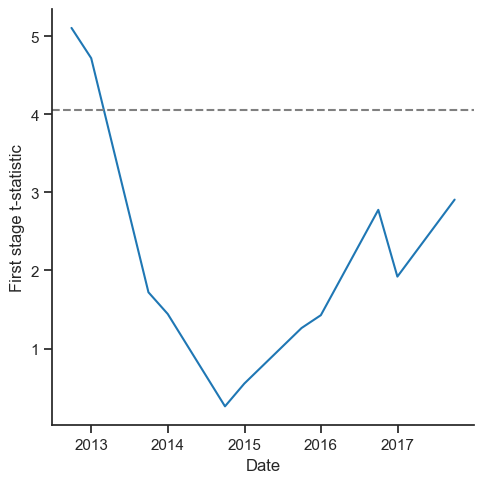

In [49]:
print('\n---------------Testing Instrument Validity---------------------------\n')
critical_value_test(df_results, characteristics, figure_path)


---------------Testing Hypothetical Index Fund---------------------------
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 53
         Function evaluations: 56
         Gradient evaluations: 56
                            NonlinearIVGMM Results                            
Dep. Variable:          Latent demand   Hansen J:                     0.004973
Model:                 NonlinearIVGMM   Prob (Hansen J):                 0.944
Method:                           GMM                                         
Date:                Fri, 22 Mar 2024                                         
Time:                        10:09:53                                         
No. Observations:                2465                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta_ln_me    13.7746     37.604      0.36

C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


MemoryError: Unable to allocate 2.05 GiB for an array with shape (4, 68944813) and data type float64

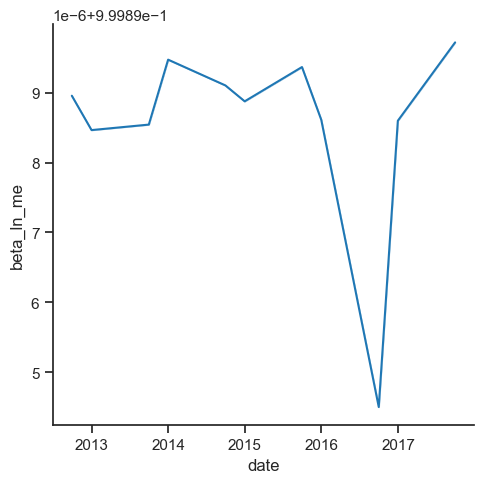

In [50]:
print('\n---------------Testing Hypothetical Index Fund---------------------------\n')
test_index_fund(df_results, characteristics, params, figure_path)

In [ ]:
print('\n---------------Creating Figures---------------------------\n')
graph_type_params(df_results, params, figure_path)

In [ ]:
graph_std_latent_demand(df_results, figure_path)
print('\n---------------Finished---------------------------\n')